In [1]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

/opt/anaconda3/envs/bertopic_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("costastziouvas/hotel-reviews-aspects-sentiments-and-topics")
print("Path to dataset files:", path)

Path to dataset files: /Users/taimanjoker/.cache/kagglehub/datasets/costastziouvas/hotel-reviews-aspects-sentiments-and-topics/versions/1


In [3]:
files = os.listdir(path)
print(files)

['HRAST_cleaned.csv', 'README.md', 'HRAST.csv']


In [4]:
file_name = 'HRAST.csv'
full_path = os.path.join(path, file_name)
df = pd.read_csv(full_path, index_col=0)

In [5]:
print(df.head())
print(df.info())

                                               review Unnamed: 2  positive  \
id                                                                           
1                             1 elevator not working.        NaN         0   
2      1 euros to park per day on their own premises.        NaN         0   
3                           1 hour queue to check-in.        NaN         0   
4   1 min walk to metro entrance and also few min ...        NaN         1   
5   1 minute walk from the main metro & train stat...        NaN         1   

    negative  neutral  Clean  Comfort  Facilities/Amenities Location  \
id                                                                     
1          1        0      0        0                     0        0   
2          0        1      0        0                     0        0   
3          1        0      0        0                     0        0   
4          0        0      0        0                     0        1   
5          0        0

# Data Preprocessing

In [6]:
# Check missing values
print(df.isnull().sum())

review                          0
Unnamed: 2                  23034
positive                        0
negative                        0
neutral                         0
Clean                           0
Comfort                         0
Facilities/Amenities            0
Location                        0
Restaurant (dinner)             0
Staff                           0
View (Balcony)                  0
Breakfast                       0
Room                            0
Pool                            0
Beach                           0
Bathroom/Shower (toilet)        0
Bar                             0
Bed                             0
Parking                         0
Noise                           0
Reception-checkin               0
Lift                            0
Value for money                 0
Wi-Fi                           0
Generic                         0
Aspect                          0
dtype: int64


In [7]:
# count unique values in 'Unnamed: 2' column and show in table format
print(df['Unnamed: 2'].value_counts(dropna=False))

# 'Unnamed: 2' column might be a 'tag' column, which might not be necessary for analysis

Unnamed: 2
NaN                                                                                23034
['Noise']                                                                              4
['Pool']                                                                               3
['Room', 'Comfort', 'Bed']                                                             3
['Bathroom']                                                                           3
['Facilities']                                                                         2
['Room', 'Generic', 'View']                                                            2
['Room', 'Facilities']                                                                 2
['Bed']                                                                                2
['Breakfast']                                                                          2
['Bar', 'Restaurant', 'Location']                                                      2
['Room', '

In [8]:
df.drop(columns=['Unnamed: 2'], inplace=True)

In [9]:
# # save dataset as a new csv file
# path = "/Users/taimanjoker/Library/CloudStorage/OneDrive-Personal/Python_Projects/Hotel/hotel_reviews"
# output_path = os.path.join(path, 'HRAST_cleaned.csv')
# df.to_csv(output_path, index=False)

# Phase 1: Setup and Exploratory Data Analysis (EDA)

In [10]:
# Analyze Overall Sentiment Distribution
# Sum the dummy columns to get the total counts
sentiment_columns = ['positive', 'negative', 'neutral']
sentiment_counts = df[sentiment_columns].sum()
print(sentiment_counts)

positive    11819
negative    10504
neutral       794
dtype: int64


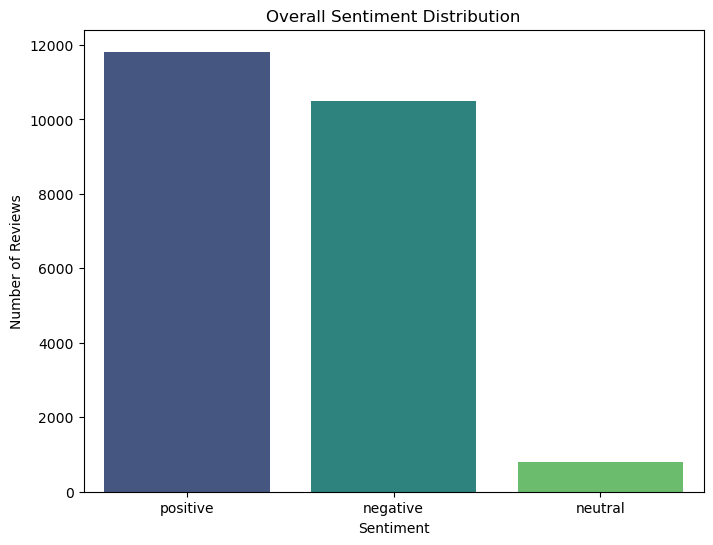

In [11]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


--- Most Discussed Aspects (Topics) ---
Room                        5004
Location                    4729
Staff                       3804
Clean                       2927
Facilities/Amenities        2923
Aspect                      2884
Comfort                     2562
Breakfast                   2539
Bathroom/Shower (toilet)    2346
Generic                     1973
dtype: int64


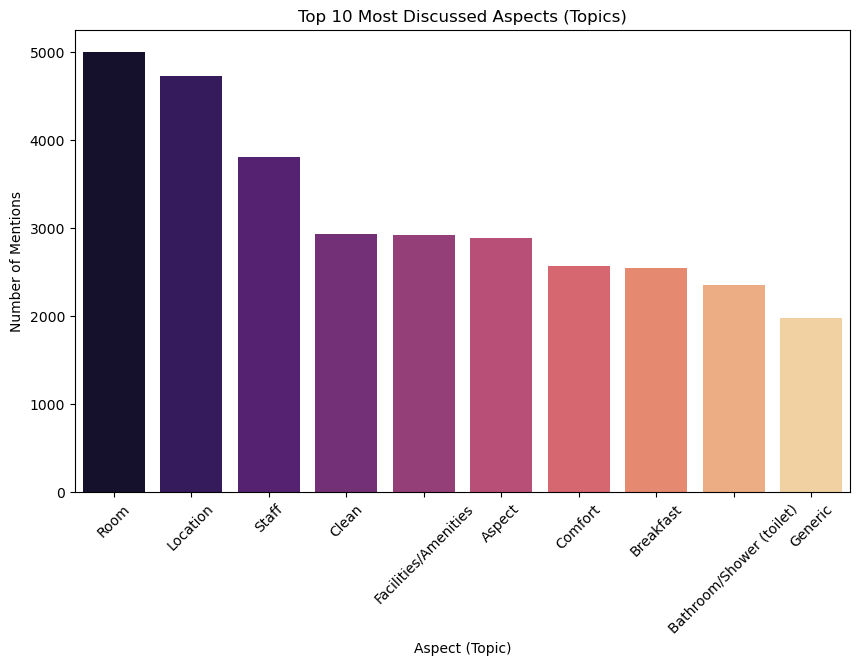

In [12]:
# Analyze Overall Aspect (Topic) Distribution
# Get all columns *except* the ones we know
potential_aspect_cols = [col for col in df.columns if col not in ['review', 'positive', 'negative', 'neutral']]

# Sum them up to see which are the most common
aspect_counts = df[potential_aspect_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).sum().sort_values(ascending=False)
print("\n--- Most Discussed Aspects (Topics) ---")
print(aspect_counts.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_counts.head(10).index, y=aspect_counts.head(10).values, palette='magma')
plt.title('Top 10 Most Discussed Aspects (Topics)')
plt.xlabel('Aspect (Topic)')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.show()


--- Most Discussed Aspects (Topics) in Negative Reviews ---
Room                        2395
Facilities/Amenities        1905
Bathroom/Shower (toilet)    1790
Clean                       1198
Noise                       1150
Breakfast                   1015
Comfort                      877
Aspect                       820
Staff                        764
Generic                      708
dtype: int64


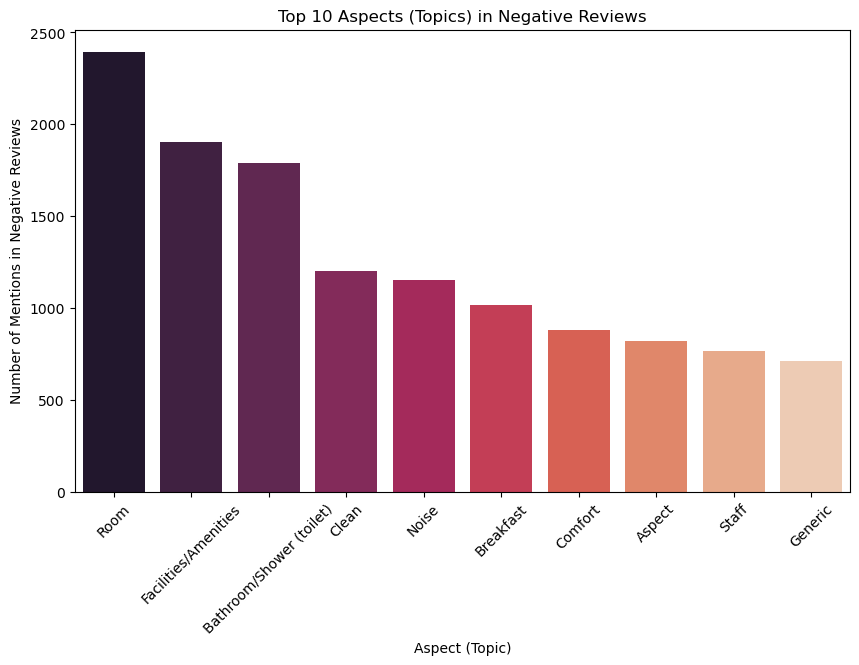

In [13]:
# What drives NEGATIVE reviews?
negative_reviews_df = df[df['negative'] == 1]

# Now, on this negative-only data, let's count the aspects
negative_aspect_counts = negative_reviews_df[potential_aspect_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).sum().sort_values(ascending=False)

print("\n--- Most Discussed Aspects (Topics) in Negative Reviews ---")
print(negative_aspect_counts.head(10))

# Visualize this "pain points" chart
plt.figure(figsize=(10, 6))
sns.barplot(x=negative_aspect_counts.head(10).index, y=negative_aspect_counts.head(10).values, palette='rocket')
plt.title('Top 10 Aspects (Topics) in Negative Reviews')
plt.xlabel('Aspect (Topic)')
plt.ylabel('Number of Mentions in Negative Reviews')
plt.xticks(rotation=45)
plt.show()

from these two charts, I can see that the painpoints are that they complaint about the 'room', 'facilities', 'bathroom', and 'clean'. A "facilities" complaint(like a broken shower) makes the "bathroom" negative, and a "room" complaint is often about "cleanliness".

The bar charts told us the "what" (e.g., "Cleanliness" is a problem). The word cloud will tell us the "why" (e.g., why is it a problem? "dust", "stains", "smell", "hair"?).

In [14]:
# Concatenate all reviews from the 'negative' == 1 rows into one giant string with WordCloud
# We also explicitly convert to string in case some reviews are numbers
all_negative_text = " ".join(review for review in df[df['negative'] == 1]['review'].astype(str))

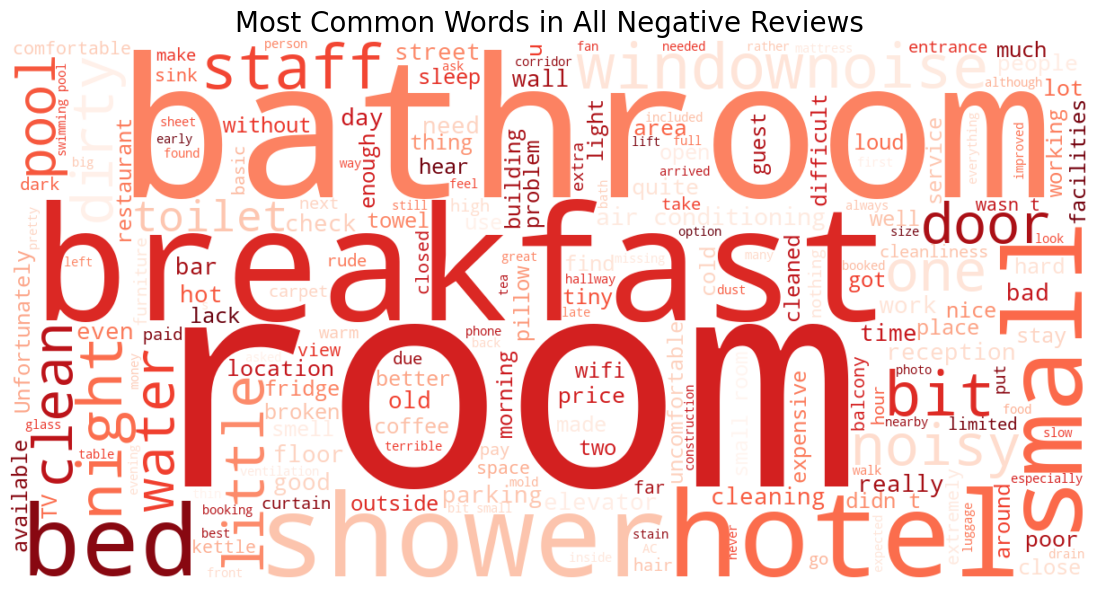

In [15]:
# Create the word cloud object
wordcloud_all_neg = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='Reds'
).generate(all_negative_text)

# Display the plot
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_all_neg, interpolation='bilinear')
plt.title('Most Common Words in All Negative Reviews', fontsize=20)
plt.axis('off')
plt.show()

As a former housekeeping supervisor, I also want to know why 'Clean' reviews are negative


--- Generating Word Cloud for Negative Reviews about 'Clean' ---


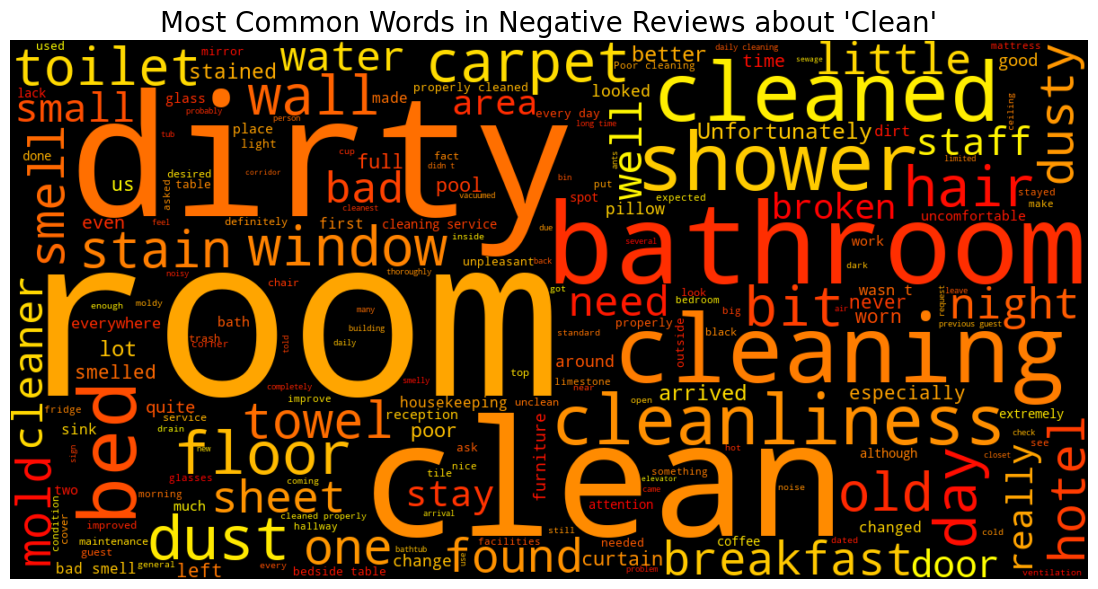

In [16]:
print("\n--- Generating Word Cloud for Negative Reviews about 'Clean' ---")

clean_negative_reviews = " ".join(review for review in df[(df['negative'] == 1) & (df['Clean'] == 1)]['review'].astype(str))

if clean_negative_reviews.strip():  # Check if there is any text to generate the word cloud
    wordcloud_clean_neg = WordCloud(
        width=1200,
        height=600,
        background_color='black', # Using different background for contrast
        colormap='autumn'
    ).generate(clean_negative_reviews)

    # Display the plot
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud_clean_neg, interpolation='bilinear')
    plt.title("Most Common Words in Negative Reviews about 'Clean'", fontsize=20)
    plt.axis('off')  # To hide the x and y axis
    plt.show()
else:
    print("No negative reviews found for the 'clean' aspect.")

In [17]:
# I will try the version that filters out some stopwords next.
# We start with the default list of English stopwords (like "the", "is", "at")
my_stopwords = set(STOPWORDS)

# Now we add our own custom words to ignore
my_stopwords.update(["clean", "cleaning", "cleaned", "cleanliness", "unclean"])


--- Generating Word Cloud for Negative Reviews about 'Clean' (with custom stopwords) ---


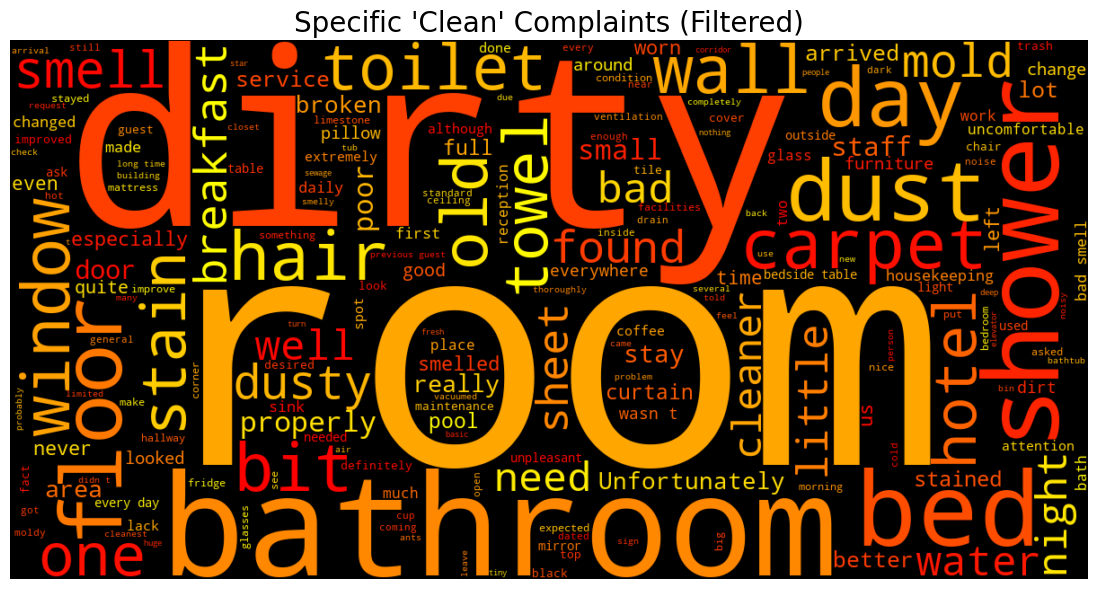

In [18]:
# Generate verion 2 of the word cloud with custom stopwords
print("\n--- Generating Word Cloud for Negative Reviews about 'Clean' (with custom stopwords) ---")
clean_negative_reviews = " ".join(review for review in df[(df['negative'] == 1) & (df['Clean'] == 1)]['review'].astype(str))

if clean_negative_reviews.strip(): 
    wordcloud_clean_neg_v2 = WordCloud(
        width=1200,
        height=600,
        background_color='black',
        colormap='autumn',
        stopwords=my_stopwords
    ).generate(clean_negative_reviews)

    # Display the plot
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud_clean_neg_v2, interpolation='bilinear')
    plt.title("Specific 'Clean' Complaints (Filtered)", fontsize=20)
    plt.axis('off')  # To hide the x and y axis
    plt.show()
else:
    print("No negative reviews found for the 'clean' aspect.")

The word cloud clearly shows 'bathroom', 'dirty', 'shower', floor', and 'toilet' as major themes.

# Phase 2: Build NLP Model

We will not use the pre-labeled columns and only use the raw 'review' text to build our own models.

## Text Preprocessing

In [19]:
# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) # The list of common English stopwords

# Define our Preprocessing Function
def preprocess_text(text):
    
    # Just in case there are non-string values
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize (split into a list of words)
    tokens = word_tokenize(text)
    
    # Remove stopwords and Lemmatize
    clean_tokens = []
    for word in tokens:
        if word not in stop_words:
            # Get the root of the word
            clean_tokens.append(lemmatizer.lemmatize(word))
            
    # Join back into a single string
    return " ".join(clean_tokens)

In [20]:
# Apply the function to our 'review' column
df['processed_review'] = df['review'].apply(preprocess_text)
print("Preprocessing complete!")

# Print the results
print("\n--- Before vs. After Preprocessing ---")
for i in range(5):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_review'].iloc[i]}\n")

Preprocessing complete!

--- Before vs. After Preprocessing ---
Original: 1 elevator not working.
Processed: elevator working

Original: 1 euros to park per day on their own premises.
Processed: euro park per day premise

Original: 1 hour queue to check-in.
Processed: hour queue checkin

Original: 1 min walk to metro entrance and also few min walk to the central station where you can access rail trains.
Processed: min walk metro entrance also min walk central station access rail train

Original: 1 minute walk from the main metro & train station, which made getting around Copenhagen extremely easy.
Processed: minute walk main metro train station made getting around copenhagen extremely easy



## Sentiment Analysis with a Deep Learning Model

We're goin to use a pre-trained Transformer model (a Deep Learning model) to get highly accurate sentiment scores.
I chose this one (`cardiffnlp/twitter-roberta-base-sentiment`) because it is well-regarded for sentiment tasks as it was trained on a large corpus of tweets with sentiment labels. Additionally, it is based on the RoBERTa architecture, which has shown strong performance in various NLP tasks.

In [21]:
# Load the model and tokenizer
# We are using a pre-trained model specifically for sentiment analysis
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment" 

# The tokenizer prepares the text for the model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
print("Model and tokenizer loaded successfully.")

# Define a function to get sentiment scores
def get_sentiment(text):
    # Truncate text to the model's max length (512 tokens)
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    
    # Run the model
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    
    # Convert scores to probabilities
    scores = softmax(scores)
    
    # The model outputs 3 scores: 0=Negative, 1=Neutral, 2=Positive
    return {
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }

Model and tokenizer loaded successfully.


### Try with 500 samples

In [22]:
# Apply the function to our processed reviews

n=500

print(f"\n--- Applying Sentiment Analysis Model on {n} Sample Reviews ---")
sample_df = df.sample(n=n, random_state=99).copy()

sentiment_scores = sample_df['processed_review'].astype(str).apply(get_sentiment)
print("Analysis of sample complete!")

# Format the results
sentiment_df = pd.DataFrame(sentiment_scores.tolist(), index=sample_df.index)

# Rename the columns to be more descriptive
sentiment_df = sentiment_df.rename(columns={
    'negative': 'negative_score',
    'neutral': 'neutral_score',
    'positive': 'positive_score'
})

# Join the new score columns back to our sample dataframe
sample_df = sample_df.join(sentiment_df)


--- Applying Sentiment Analysis Model on 500 Sample Reviews ---
Analysis of sample complete!


In [23]:
# Display the results
print("\n--- Sample Reviews with Sentiment Scores ---")
display(sample_df[[
    'review', 
    'processed_review', 
    'negative_score', 
    'neutral_score', 
    'positive_score'
]].head())


--- Sample Reviews with Sentiment Scores ---


,review,processed_review,negative_score,neutral_score,positive_score
id,,,,,
16023,The location and comfort of the hotel were super.,location comfort hotel super,0.005930,0.247660,0.746410
17803,The room was clean and nice.,room clean nice,0.006112,0.088445,0.905443
20831,Toilet/bathroom too narrow.,toiletbathroom narrow,0.201333,0.738852,0.059816
13820,"The bathroom could be renewed (fumes, a classi...",bathroom could renewed fume classic refurnishi...,0.061755,0.857468,0.080777
9968,Noisy in the night.,noisy night,0.387135,0.531482,0.081383


In [24]:
# Take a look at what our model thinks are the MOST negative reviews
print("\n--- Most Negative Reviews according to the Model ---")
display(sample_df.sort_values(by='negative_score', ascending=False)[['review', 'negative_score']].head())


--- Most Negative Reviews according to the Model ---


,review,negative_score
id,,
18062,The room was really disappointing for a “Premi...,0.967603
21937,Very rude and unprofessional staff.,0.964103
17067,The pool in the room was malfunctioning if it ...,0.957294
13712,"The area is central but is really disgusting, ...",0.953072
16576,The location wasn’t very good for family.,0.949695


## 3. Topic Modeling with BERTopic

Latent Dirichlet Allocation (LDA) identifies topics by analysing word co-occurrences. While powerful, it lacks semantic understanding.  It groups frequently co-occurring words, but the resulting topics may lack intuitive coherence.

In contrast, BERTopic employs transformer models to grasp word context and semantics. This allows it to generate more meaningful and relevant topics by considering actual word meanings and sentence relationships.  Consequently, it often produces topics that align better with human understanding.

LDA treats “staff” and “employee” as distinct words, grouping them only when they frequently appear together in reviews.  BERTopic, however, uses the same Transformer “brain” (like RoBERTa) employed for sentiment analysis. It recognises that “staff” and “employee” are nearly synonymous.  It clusters reviews based on semantic meaning rather than just word counts, resulting in incredibly accurate, human-like topics.

LDA requires manual specification of the number of topics (e.g., “find 10 topics”), relying on guesswork.  BERTopic, on the other hand, employs a clustering algorithm (HDBSCAN) that automatically determines the optimal number of topics in the data.  It also identifies outliers (reviews not fitting any topic) and labels them as Topic -1, which is invaluable for filtering noise.

In [25]:
# Prepare the documents
# BERTopic works on a simple list of strings (documents)
# So we must drop any empty/missing reviews.
docs = df['processed_review'].astype(str).dropna().tolist()

# Initialize BERTopic with reproducible results
print(f"Starting BERTopic modeling on {len(docs)} reviews...")

# BERTopic uses UMAP for dimensionality reduction and HDBSCAN for clustering

# Configure UMAP with a fixed random_state
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=99)

# Configure HDBSCAN (it doesn't have random_state, but we can make it more stable)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Initialize BERTopic with these components
topic_model = BERTopic(
    language="english",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
    calculate_probabilities=True
)

# It will find the topics and assign a topic to each review
topics, probabilities = topic_model.fit_transform(docs)

# See the results
print("\n--- Top Topics Found by BERTopic ---")

# I use .get_topic_info() to give a clean DataFrame of all topics.
display(topic_model.get_topic_info())

2025-11-14 08:35:00,495 - BERTopic - Embedding - Transforming documents to embeddings.


Starting BERTopic modeling on 23113 reviews...


Batches:   0%|          | 0/723 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Batches: 100%|██████████| 723/723 [00:10<00:00, 68.73it/s]
2025-11-14 08:35:14,882 - BERTopic - Embedding - Completed ✓
2025-11-14 08:35:14,883 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-14 08:35:38,323 - BERTopic - Dimensionality - Completed ✓
2025-11-14 08:35:38,324 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicit


--- Top Topics Found by BERTopic ---


,Topic,Count,Name,Representation,Representative_Docs
0,-1,6129,-1_noise_breakfast_reception_bathroom,"[noise, breakfast, reception, bathroom, floor,...",[room small like sink bathroom door toilet fro...
1,0,553,0_hotel_located_accommodation_charming,"[hotel, located, accommodation, charming, styl...","[location hotel good, hotel, hotel]"
2,1,229,1_wifi_internet_connection_weak,"[wifi, internet, connection, weak, signal, fre...","[wifi room, wifi, wifi]"
3,2,220,2_shower_cabin_bath_slippery,"[shower, cabin, bath, slippery, wc, large, sma...","[shower good, shower, shower good]"
4,3,215,3_staff_location_helpful_friendly,"[staff, location, helpful, friendly, welcoming...","[great location friendly helpful staff, friend..."
...,...,...,...,...,...
328,327,15,327_gothic_quarter_bario_gothico,"[gothic, quarter, bario, gothico, beach, favou...","[location near gothic quarter great, good loca..."
329,328,15,328_egg_scrambled_boiled_bacon,"[egg, scrambled, boiled, bacon, cooked, cold, ...","[scrambled egg pretty bad, good breakfast scra..."
330,329,15,329_luck_goodness_dangling_designation,"[luck, goodness, dangling, designation, hostel...",[hard hit poor designation average standard ro...
331,330,15,330_rambla_la_ramblas_waling,"[rambla, la, ramblas, waling, surely, scale, p...","[location best step la rambla center, convenie..."


The outlier topic (-1) contains all the reviews that BERTopic decided didn't really fit into any other main theme. We can use it for filtering out generic, unhelpful reviews.

In [26]:
# Visualize the top 5 topics using BERTopic's built-in visualization
fig = topic_model.visualize_barchart(top_n_topics=5)
fig.show()

In [27]:
# Inspect a specific topic
# Let's see the words for the first (an d biggest) topic, Topic 0
print("\n--- Words in Topic 0 ---")
display(topic_model.get_topic(0))


--- Words in Topic 0 ---


[('hotel', np.float64(0.03237533149972376)),
 ('located', np.float64(0.010128469231928247)),
 ('accommodation', np.float64(0.009161277392787088)),
 ('charming', np.float64(0.008687209114379356)),
 ('style', np.float64(0.00734537431509373)),
 ('location', np.float64(0.006902699326925466)),
 ('center', np.float64(0.006895888243789104)),
 ('city', np.float64(0.006879128772307341)),
 ('centrally', np.float64(0.006719357905843443)),
 ('character', np.float64(0.006719061542769885))]

In [28]:
# Add topics back to our DataFrame
# 'topics' list is shorter than 'df' if we dropped NaNs, so we add it to the DataFrame that we've filtered.
df_with_topics = df.dropna(subset=['processed_review']).copy()
df_with_topics['topic'] = topics

print("\n--- DataFrame with new 'topic' column ---")
display(df_with_topics[['review', 'processed_review', 'topic']].head())


--- DataFrame with new 'topic' column ---


,review,processed_review,topic
id,,,
1,1 elevator not working.,elevator working,72
2,1 euros to park per day on their own premises.,euro park per day premise,267
3,1 hour queue to check-in.,hour queue checkin,10
4,1 min walk to metro entrance and also few min ...,min walk metro entrance also min walk central ...,5
5,1 minute walk from the main metro & train stat...,minute walk main metro train station made gett...,54


In [29]:
display(topic_model.get_topic(26))

[('airport', np.float64(0.19112264777651394)),
 ('train', np.float64(0.034557381068202164)),
 ('easy', np.float64(0.027915198895857887)),
 ('stop', np.float64(0.02766868205331138)),
 ('shuttle', np.float64(0.024247664068086105)),
 ('bus', np.float64(0.02303582114846927)),
 ('access', np.float64(0.02298351122597761)),
 ('flight', np.float64(0.02241627439999022)),
 ('close', np.float64(0.01985568123891964)),
 ('min', np.float64(0.017090783463822968))]

# Phase 3: Final Analysis (The Dashboard)

Our goal now is to create one final, powerful table that ranks every topic by its average negative sentiment score which will be my "Top Pain Points" Dashboard.

In [30]:
# Apply Sentiment to all topics
# Not just 500 samples this time
print("--- Starting Full Sentiment Analysis ---")
print(f"This will process {len(df_with_topics)} reviews.")

# Create a copy to work on
final_df = df_with_topics.copy()

sentiment_scores = final_df['processed_review'].astype(str).apply(get_sentiment)

--- Starting Full Sentiment Analysis ---
This will process 23113 reviews.


In [31]:
# Combine data
sentiment_df = pd.DataFrame(sentiment_scores.tolist(), index=final_df.index)

# Rename the columns to be more descriptive
sentiment_df = sentiment_df.rename(columns={
    'negative': 'negative_score',
    'neutral': 'neutral_score',
    'positive': 'positive_score'
})

# Join the new score columns back to the main dataframe
final_df = final_df.join(sentiment_df)

In [32]:
# Analyze and rank 'Pain Points'
print("\n--- Analyzing Top Pain Points ---")

# First, let's get our topic names from the model
topic_info = topic_model.get_topic_info()

# Filter out the 'junk' topic (-1)
final_df_filtered = final_df[final_df['topic'] != -1]

# Group by 'topic' and calculate the mean of the scores
topic_sentiment = final_df_filtered.groupby('topic').agg(
    negative_score_mean=('negative_score', 'mean'),
    positive_score_mean=('positive_score', 'mean'),
    review_count=('topic', 'size')
).reset_index()

# Merge with the topic names from BERTopic
topic_sentiment = topic_sentiment.merge(
    topic_info[['Topic', 'Name', 'Representation']],
    left_on='topic',
    right_on='Topic'
)

# Sort to find the topics with the highest average negative score
top_pain_points = topic_sentiment.sort_values(by='negative_score_mean', ascending=False)


--- Analyzing Top Pain Points ---


In [33]:
# Display the final result
print("\n--- Top Pain Points Ranked by Average Negative Sentiment ---")
display(top_pain_points[[
    'Name',
    'negative_score_mean',
    'positive_score_mean',
    'review_count',
    'Representation'
]])

# What are the topics that make guests the angriest?


--- Top Pain Points Ranked by Average Negative Sentiment ---


,Name,negative_score_mean,positive_score_mean,review_count,Representation
306,306_rude_reception_unprofessional_attitude,0.854756,0.019695,18,"[rude, reception, unprofessional, attitude, un..."
158,158_rude_unhelpful_indifferent_occasion,0.834102,0.022830,40,"[rude, unhelpful, indifferent, occasion, inter..."
319,319_bad_awful_quallity_rasher,0.818519,0.046847,17,"[bad, awful, quallity, rasher, sadest, cesar, ..."
329,329_luck_goodness_dangling_designation,0.737875,0.052382,15,"[luck, goodness, dangling, designation, hostel..."
23,23_smell_sewage_coming_sewer,0.720096,0.035869,107,"[smell, sewage, coming, sewer, drain, smelled,..."
...,...,...,...,...,...
139,139_reakfast_excellent_breakfast_twostar,0.004547,0.916567,44,"[reakfast, excellent, breakfast, twostar, elab..."
193,193_competition_twobedroom_assigning_accomplished,0.004442,0.906160,31,"[competition, twobedroom, assigning, accomplis..."
208,208_delicious_homebaked_crispbread_porridge,0.003343,0.922472,29,"[delicious, homebaked, crispbread, porridge, k..."
295,295_hangout_nice_twin_let,0.003294,0.953925,19,"[hangout, nice, twin, let, opened, say, lookin..."


In [34]:
# Filter reviews for topic 158
topic_158_reviews = final_df[final_df['topic'] == 158][['review', 'negative_score', 'positive_score']].sort_values(by='negative_score', ascending=False)

print(f"\n--- All Reviews in Topic 158 (rude_unprofessional_reception_unfriendly) ---")
print(f"Total reviews: {len(topic_158_reviews)}\n")
display(topic_158_reviews)


--- All Reviews in Topic 158 (rude_unprofessional_reception_unfriendly) ---
Total reviews: 40



,review,negative_score,positive_score
id,,,
19034,The staff is extremely disrespectful and unfri...,0.978172,0.002944
19323,The staff we interacted with was really rude a...,0.976829,0.002499
3287,Couldn't believe how unhelpful and rude they w...,0.976827,0.002842
12224,Rude and unhelpful staff.,0.976525,0.002785
9319,Night staff were extremely rude and unhelpful ...,0.976258,0.002275
13126,Staff was rude and unhelpful.,0.972819,0.003433
21937,Very rude and unprofessional staff.,0.964103,0.003948
12222,"Rude and inexperienced staff manger, lack of Q...",0.963244,0.002808
13228,Staff were rude & pretentious.,0.951729,0.006275


In [35]:
print("--- Creating Final Prioritization Matrix ---")

# Get Topic Info
topic_info = topic_model.get_topic_info()

# Filter out the "junk" topic (-1)
final_df_filtered = final_df[final_df['topic'] != -1]

# Group by 'topic' and calculate metrics
topic_analysis = final_df_filtered.groupby('topic').agg(
    negative_score_mean=('negative_score', 'mean'),
    positive_score_mean=('positive_score', 'mean'),
    neutral_score_mean=('neutral_score', 'mean'),
    review_count=('topic', 'size')  # This is the 'Count'
).reset_index()

# Merge with Topic Names
topic_analysis = topic_analysis.merge(
    topic_info[['Topic', 'Name', 'Representation']], 
    left_on='topic', 
    right_on='Topic'
)

# Create the Final "Prioritization" Dashboard
final_dashboard = topic_analysis.sort_values(
    by=['negative_score_mean', 'review_count'], 
    ascending=[False, False]
)

print("\n\n=== FINAL PRIORITIZATION DASHBOARD ===\n")
print("Sorted by SEVERITY (most negative) first.")
display(final_dashboard[[
    'Name', 
    'negative_score_mean', 
    'review_count',
    'Representation'
]])

print("\n\n=== MOST FREQUENT TOPICS ===\n")
print("Sorted by FREQUENCY (most common) first.")
display(final_dashboard.sort_values(by='review_count', ascending=False)[[
    'Name', 
    'review_count',
    'negative_score_mean', 
    'Representation'
]])

--- Creating Final Prioritization Matrix ---


=== FINAL PRIORITIZATION DASHBOARD ===

Sorted by SEVERITY (most negative) first.


,Name,negative_score_mean,review_count,Representation
306,306_rude_reception_unprofessional_attitude,0.854756,18,"[rude, reception, unprofessional, attitude, un..."
158,158_rude_unhelpful_indifferent_occasion,0.834102,40,"[rude, unhelpful, indifferent, occasion, inter..."
319,319_bad_awful_quallity_rasher,0.818519,17,"[bad, awful, quallity, rasher, sadest, cesar, ..."
329,329_luck_goodness_dangling_designation,0.737875,15,"[luck, goodness, dangling, designation, hostel..."
23,23_smell_sewage_coming_sewer,0.720096,107,"[smell, sewage, coming, sewer, drain, smelled,..."
...,...,...,...,...
139,139_reakfast_excellent_breakfast_twostar,0.004547,44,"[reakfast, excellent, breakfast, twostar, elab..."
193,193_competition_twobedroom_assigning_accomplished,0.004442,31,"[competition, twobedroom, assigning, accomplis..."
208,208_delicious_homebaked_crispbread_porridge,0.003343,29,"[delicious, homebaked, crispbread, porridge, k..."
295,295_hangout_nice_twin_let,0.003294,19,"[hangout, nice, twin, let, opened, say, lookin..."




=== MOST FREQUENT TOPICS ===

Sorted by FREQUENCY (most common) first.


,Name,review_count,negative_score_mean,Representation
0,0_hotel_located_accommodation_charming,553,0.066467,"[hotel, located, accommodation, charming, styl..."
1,1_wifi_internet_connection_weak,229,0.418512,"[wifi, internet, connection, weak, signal, fre..."
2,2_shower_cabin_bath_slippery,220,0.190385,"[shower, cabin, bath, slippery, wc, large, sma..."
3,3_staff_location_helpful_friendly,215,0.011037,"[staff, location, helpful, friendly, welcoming..."
4,4_conditioning_air_conditioner_work,207,0.305317,"[conditioning, air, conditioner, work, summer,..."
...,...,...,...,...
328,328_egg_scrambled_boiled_bacon,15,0.319925,"[egg, scrambled, boiled, bacon, cooked, cold, ..."
330,330_rambla_la_ramblas_waling,15,0.035714,"[rambla, la, ramblas, waling, surely, scale, p..."
325,325_chair_worn_dirty_furniture,15,0.581897,"[chair, worn, dirty, furniture, previous, unde..."
331,331_terrace_garden_lawn_alternatively,15,0.034815,"[terrace, garden, lawn, alternatively, courtya..."


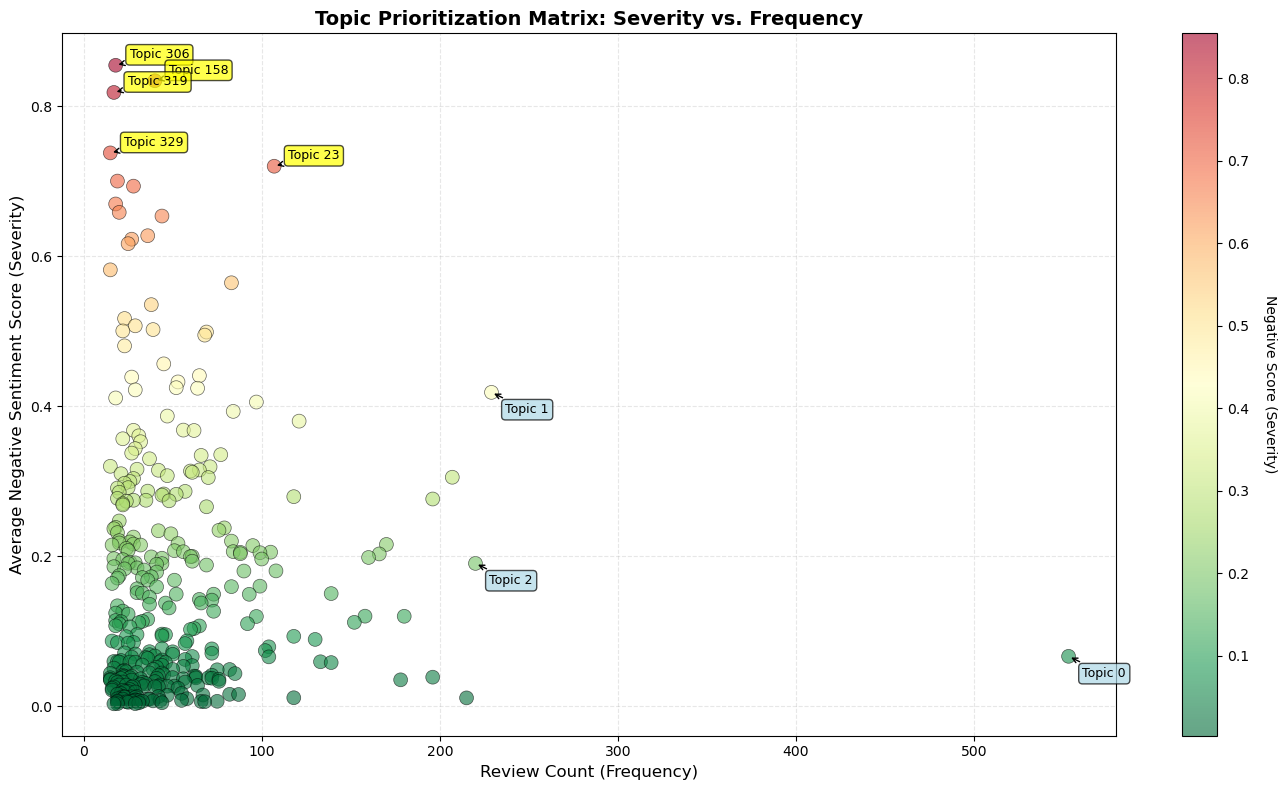

In [36]:
# Create a scatter plot to visualize the Prioritization Matrix
plt.figure(figsize=(14, 8))


scatter = plt.scatter(
    final_dashboard['review_count'], 
    final_dashboard['negative_score_mean'],
    s=100,  
    alpha=0.6,
    c=final_dashboard['negative_score_mean'],  # Color by severity
    cmap='RdYlGn_r',  # red = high severity
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Negative Score (Severity)', rotation=270, labelpad=20)

# Add labels and title
plt.xlabel('Review Count (Frequency)', fontsize=12)
plt.ylabel('Average Negative Sentiment Score (Severity)', fontsize=12)
plt.title('Topic Prioritization Matrix: Severity vs. Frequency', fontsize=14, fontweight='bold')

# Add grid 
plt.grid(True, alpha=0.3, linestyle='--')

# Annotate the top 5 most severe topics
top_severe = final_dashboard.nlargest(5, 'negative_score_mean')
for idx, row in top_severe.iterrows():
    # Extract just the topic number from the Name column
    topic_num = row['Name'].split('_')[0]
    plt.annotate(
        f"Topic {topic_num}",
        (row['review_count'], row['negative_score_mean']),
        xytext=(10, 5),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1)
    )

# Annotate the top 3 most frequent topics
top_frequent = final_dashboard.nlargest(3, 'review_count')
for idx, row in top_frequent.iterrows():
    topic_num = row['Name'].split('_')[0]
    plt.annotate(
        f"Topic {topic_num}",
        (row['review_count'], row['negative_score_mean']),
        xytext=(10, -15),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1)
    )

plt.tight_layout()
plt.show()